In [6]:
import pandas as pd
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Maric acid', 'Ash', 'Alcalinity of ash','Magnesium',
                   'Total phenols','Flavanoids','Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity',
                   'Hue','OD280/OD315 of diluted wines', 'Proline']

from sklearn.model_selection import train_test_split
X,y = df_wine.iloc[:, 1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=0)

# 標準化
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

In [7]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1')


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
lr = LogisticRegression(penalty='l1' , C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std,y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

print('intercept', lr.intercept_)
print('coef',lr.coef_)

Training accuracy: 0.983870967742
Test accuracy: 0.981481481481
intercept [-0.38380018 -0.15815202 -0.70043361]
coef [[ 0.2802926   0.          0.         -0.02793707  0.          0.
   0.7101137   0.          0.          0.          0.          0.
   1.23623753]
 [-0.64371473 -0.06892075 -0.05716787  0.          0.          0.          0.
   0.          0.         -0.92724726  0.05968557  0.         -0.37097178]
 [ 0.          0.06151893  0.          0.          0.          0.
  -0.63591525  0.          0.          0.49805586 -0.3582098  -0.57132037
   0.        ]]


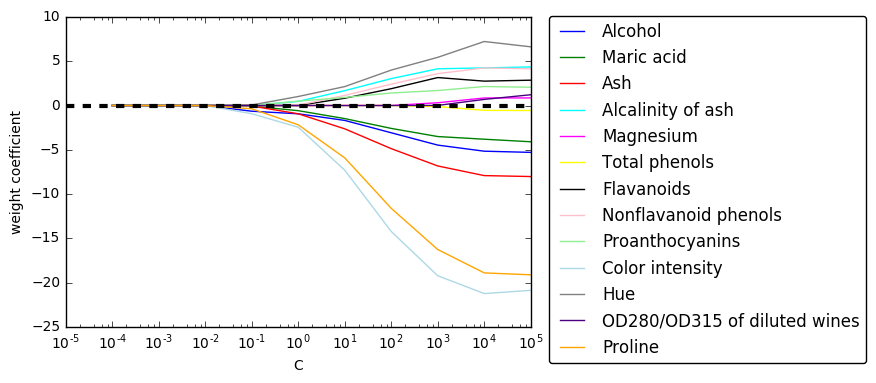

In [19]:
import matplotlib.pyplot as plt

fig= plt.figure()
ax = plt.subplot(111)
colors =['blue','green','red','cyan','magenta','yellow','black','pink','lightgreen','lightblue','gray','indigo','orange']

weights, params = [], []

for c in np.arange(-4,6):
    lr = LogisticRegression(penalty='l1' , C=10**c ,random_state=0)
    lr.fit(X_train_std,y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params,weights[:, column],label=df_wine.columns[column+1],color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
#plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
plt.show()